# Moving Average Analysis of Shape Variables

In [ ]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score



# Generate Original CSV, and  CSV with Moving Average(MA) 
# Cell_IDs_vs_Frames_Distribution 
# Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
# Ensure inclusion of cells appearing in at least 5 frames

Found 100 mask files.


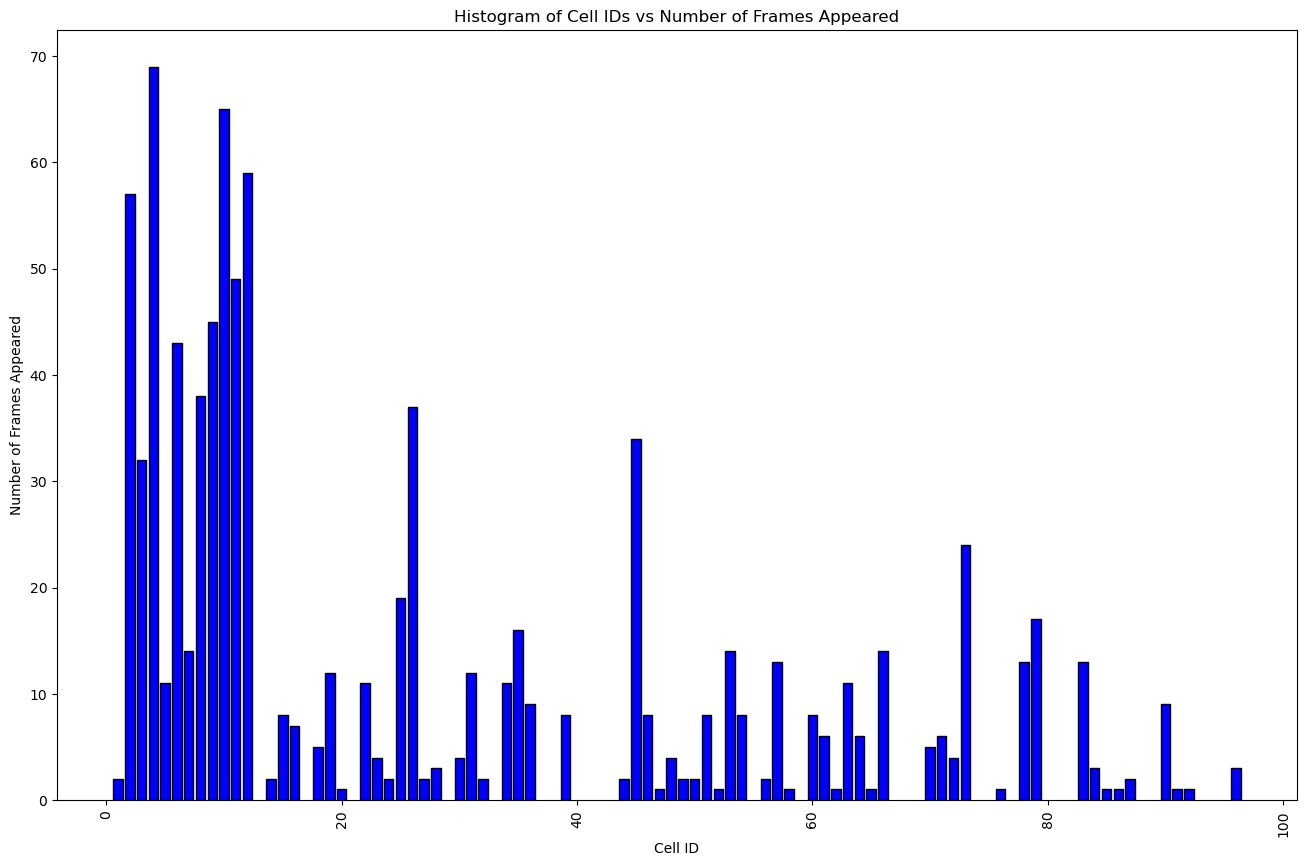

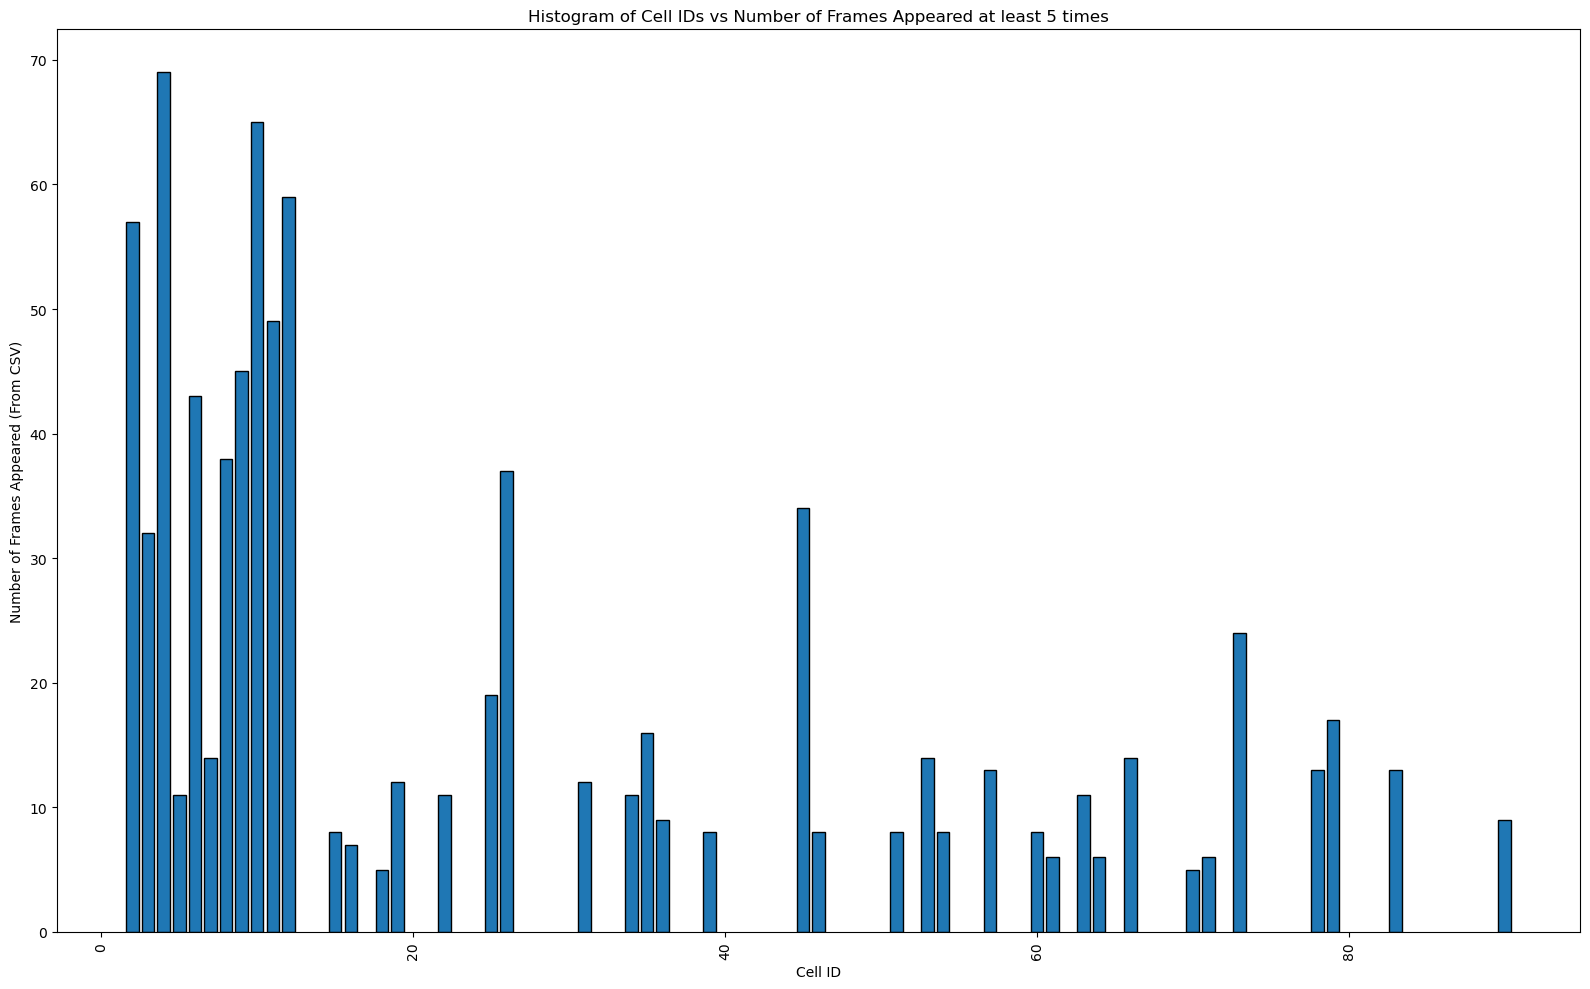

    Cell Number                                    Frames Appeared
0             2  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...
1             3  [1, 2, 4, 5, 8, 9, 16, 18, 19, 20, 34, 35, 36,...
2             4  [2, 3, 4, 6, 7, 8, 10, 11, 19, 20, 21, 23, 24,...
3             5            [2, 3, 4, 7, 8, 13, 14, 15, 72, 79, 85]
4             6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5             7   [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
6             8  [1, 2, 3, 4, 37, 38, 45, 47, 49, 50, 51, 55, 5...
7             9  [3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17,...
8            10  [3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 22...
9            11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10           12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
11           15                    [9, 27, 44, 49, 55, 56, 67, 68]
12           16                         [5, 9, 11, 38, 64, 65, 66]
13           18                                [2, 19, 20, 23,

In [7]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20, window_size=5):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]
    
    os.makedirs(output_directory, exist_ok=True)
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # window_size=5


    # os.makedirs(output_directory, exist_ok=True)
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)
    
    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # calculate the frame list
    frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL_{window_size}.csv"), index=False)
    # Separate Chunk for Moving Average Calculation
    moving_average_variables = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    # window_size = 5

    for var in moving_average_variables:
        df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
    df.to_csv(ma_csv_path, index=False)


    # frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    plt.figure(figsize=(16, 10))
    plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared")
    plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
    plt.show()


    # Additional Bar Plot from "Cells_Frames_List_HP4_Sign_AL_{window_size}.csv"
    frame_list_csv_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL_{window_size}.csv")
    if os.path.exists(frame_list_csv_path):
        frame_list_df = pd.read_csv(frame_list_csv_path)
        frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

        plt.figure(figsize=(16, 10))
        plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
        plt.xlabel("Cell ID")
        plt.ylabel("Number of Frames Appeared (From CSV)")
        plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
        plt.show()
    else:
        print(f"Warning: {frame_list_csv_path} not found. Skipping additional bar plot.")





    print(frame_list)
    print(f"Original results saved at: {original_csv_path}")
    print(f"Results with moving averages saved at: {ma_csv_path}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    
    return df





    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    
    # print(frame_list)
    # print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    # return df


#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))


# Original VS Moving Average of Cells_Centroid_Velocity plot for a particular cell

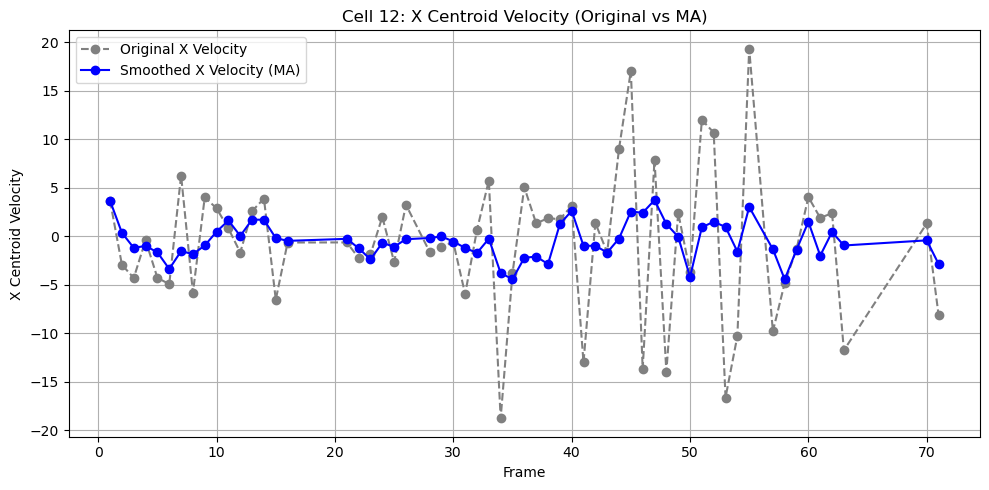

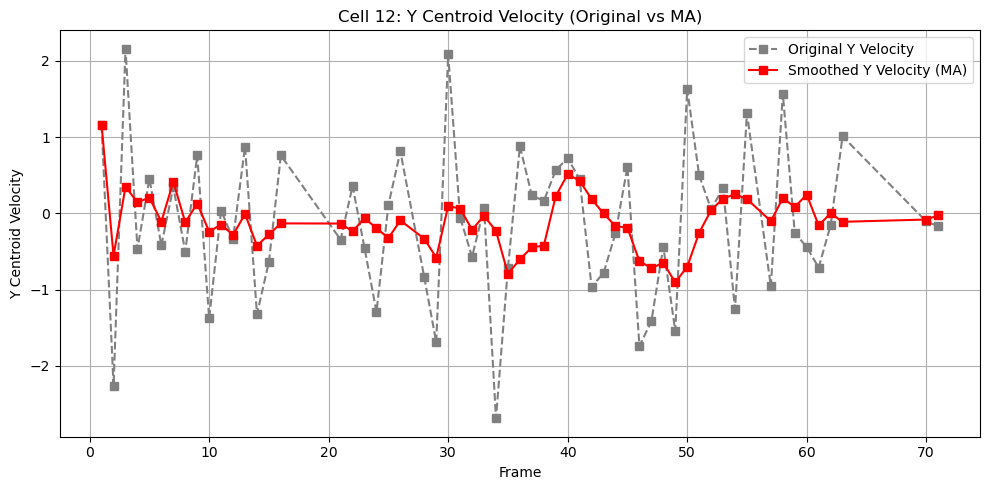

In [11]:
def plot_cell_velocity_comparison(output_directory, cell_id, window_size):
    # File paths
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")

    # Check if files exist
    if not os.path.exists(ma_csv_path) or not os.path.exists(original_csv_path):
        print(f"Error: Required CSV files not found in {output_directory}")
        return

    # Load data
    df_ma = pd.read_csv(ma_csv_path)
    df_orig = pd.read_csv(original_csv_path)

    # Filter by Cell ID
    cell_ma = df_ma[df_ma["Cell Number"] == cell_id]
    cell_orig = df_orig[df_orig["Cell Number"] == cell_id]

    if cell_ma.empty or cell_orig.empty:
        print(f"No data found for Cell ID: {cell_id}")
        return

    # Sort frames just in case
    cell_ma = cell_ma.sort_values(by="Frame")
    cell_orig = cell_orig.sort_values(by="Frame")

    # Plot X Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["X_Centroid_Velocity"], marker='o', linestyle='--', color='gray', label='Original X Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["X_Centroid_Velocity_MA"], marker='o', linestyle='-', color='blue', label='Smoothed X Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("X Centroid Velocity")
    plt.title(f"Cell {cell_id}: X Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"X-Centroid_Velocity(Original VS Moving Average)_{window_size}_{cell_id}.png"))
    plt.show()

    # Plot Y Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["Y_Centroid_Velocity"], marker='s', linestyle='--', color='gray', label='Original Y Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["Y_Centroid_Velocity_MA"], marker='s', linestyle='-', color='red', label='Smoothed Y Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("Y Centroid Velocity")
    plt.title(f"Cell {cell_id}: Y Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, f"Y-Centroid_Velocity(Original VS Moving Average)_{window_size}_{cell_id}.png"))
    plt.show()


# Example Usage
# plot_cell_velocity("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/", cell_id=2, window_size=5)
plot_cell_velocity_comparison("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/",12,5)


# Generate Original CSV, and  CSV with Moving Average(MA) 

In [35]:


def analyze_cells_across_frames(mask_directory, output_directory,window_size, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", 
                                            "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]



    # df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", 
    #                                         "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", 
    #                                         "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", 
    #                                         "X_Centroid_Velocity", "Y_Centroid_Velocity"])

    # df = df[df["X_Centroid_Velocity"] != 0 & df["Y_Centroid_Velocity"] != 0]
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(output_directory, exist_ok=True)
    # window_size = 5

    # Save original data
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)

    # Compute and save moving averages
    # window_size = 5
    moving_average_variables = df.columns.difference(["Cell Number", "Frame"])
    ma_df = df[["Cell Number", "Frame"]].copy()

    for var in moving_average_variables:
        ma_df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
    ma_df.to_csv(ma_csv_path, index=False)

    print(f"✅ Original CSV saved at: {original_csv_path}")
    print(f"✅ Moving Average CSV saved at: {ma_csv_path}")
    
    return df



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"
window_size=5

results_df = analyze_cells_across_frames(mask_directory, output_directory, window_size)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))


Found 100 mask files.
✅ Original CSV saved at: /home/MinaHossain/EmbedTrack/Moving_Average-Shape/Cells_Centroid_Velocity_Original_5.csv
✅ Moving Average CSV saved at: /home/MinaHossain/EmbedTrack/Moving_Average-Shape/Cells_Centroid_Velocity_MA_5.csv
    Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
13            2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
14            3      1  34825.0  1027.210245  0.877867  0.578613     0.414746   
18            6      1  31475.0  1058.239682  0.805502  0.516678     0.353189   
20            8      1  52912.0  1613.896536  0.829875  0.756902     0.255278   
23           11      1  20481.0   673.889394  0.984285  0.776089     0.566740   
24           12      1  76329.0  3385.869191  0.584762  0.391128     0.083668   
26            2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
27            3      2  36500.0  1161.210245  0.845632  0.584833     0.340158   
29            4      

# Moving Average plot of a particular cell id (Frame VS X_Centroid_Velocity_MA ,Frame VS Y_Centroid_Velocity_MA )(Next One is better !)

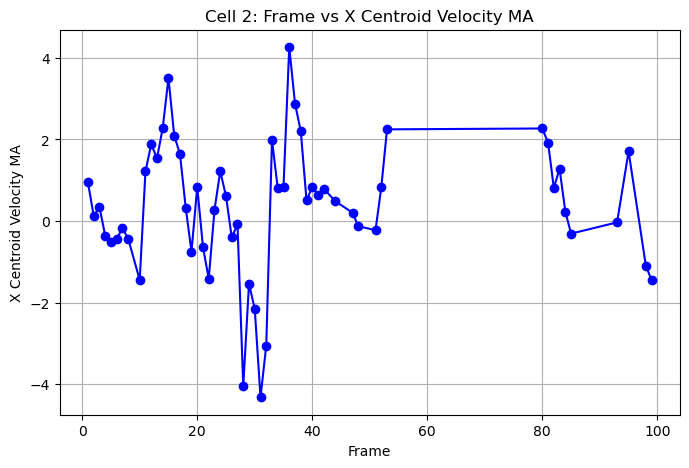

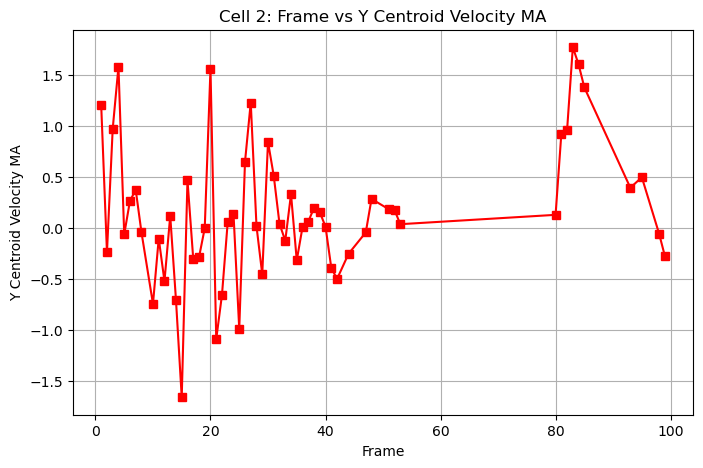

In [15]:

def plot_cell_velocity(output_directory, cell_id):
    # Generate the expected file path
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_5.csv")

    # Check if the file exists
    if not os.path.exists(ma_csv_path):
        print(f"Error: File not found - {ma_csv_path}")
        return

    df = pd.read_csv(ma_csv_path)
    cell_data = df[df["Cell Number"] == cell_id]

    if cell_data.empty:
        print(f"No data found for Cell ID: {cell_id}")
        return

    plt.figure(figsize=(8, 5))
    plt.plot(cell_data["Frame"], cell_data["X_Centroid_Velocity_MA"], marker='o', linestyle='-', color='b')
    plt.xlabel("Frame")
    plt.ylabel("X Centroid Velocity MA")
    plt.title(f"Cell {cell_id}: Frame vs X Centroid Velocity MA")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(cell_data["Frame"], cell_data["Y_Centroid_Velocity_MA"], marker='s', linestyle='-', color='r')
    plt.xlabel("Frame")
    plt.ylabel("Y Centroid Velocity MA")
    plt.title(f"Cell {cell_id}: Frame vs Y Centroid Velocity MA")
    plt.grid(True)
    plt.show()

# Example Usage
plot_cell_velocity("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/", cell_id=2)

# Generate a Original CSV, CSV with Moving Average(MA) and  merged dataset combining original and moving average values 
# Data set for PCA, t-SNE, PHATE
# We will do many PCA plots from here

In [2]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""

    start_time = time.time()

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    previous_centroids = {}
    previous_frames = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]
                    y_dist = centroid[1] - prev_centroid[1]
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x
                y_centroid_distance = centroid[1] - prev_y
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent", "Circularity", "Convexity", "Elongation", "Compactness", 
                                            "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])

    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(output_directory, exist_ok=True)
    window_size = 5

    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)

    moving_average_variables = df.columns.difference(["Cell Number", "Frame"])
    ma_df = df[["Cell Number", "Frame"]].copy()

    for var in moving_average_variables:
        ma_df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
    ma_df.to_csv(ma_csv_path, index=False)

    # Merge original and moving average DataFrames
    merged_df = pd.merge(df, ma_df.drop(columns=["Cell Number", "Frame"]), left_index=True, right_index=True)
    merged_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Merged_{window_size}.csv")
    merged_df.to_csv(merged_csv_path, index=False)

    print(f"\n✅ Original CSV saved at: {original_csv_path}")
    print(f"✅ Moving Average CSV saved at: {ma_csv_path}")
    print(f"✅ Merged CSV saved at: {merged_csv_path}")

    return df



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))

Found 100 mask files.

✅ Original CSV saved at: /home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_Original_5.csv
✅ Moving Average CSV saved at: /home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_MA_5.csv
✅ Merged CSV saved at: /home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_Merged_5.csv
    Cell Number  Frame     Area    Perimeter  Solidity    Extent  Circularity  \
13            2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
14            3      1  34825.0  1027.210245  0.877867  0.578613     0.414746   
18            6      1  31475.0  1058.239682  0.805502  0.516678     0.353189   
20            8      1  52912.0  1613.896536  0.829875  0.756902     0.255278   
23           11      1  20481.0   673.889394  0.984285  0.776089     0.566740   
24           12      1  76329.0  3385.869191  0.584762  0.391128     0.083668   
26            2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
27    

# Moving Average plot of a particular cell id (Frame VS X_Centroid_Velocity_MA , Frame VS X_Centroid_Velocity) and ( Frame VS Y_Centroid_Velocity_MA, Frame VS Y_Centroid_Velocity) 

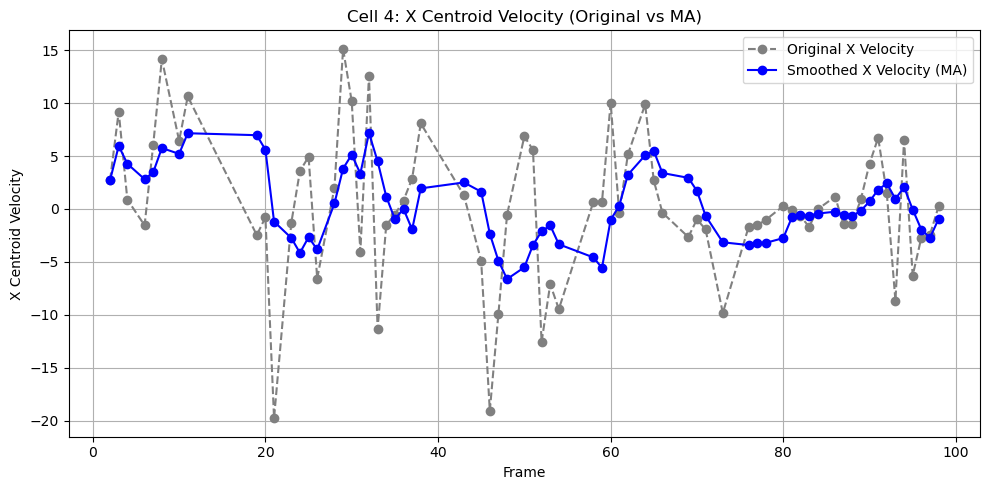

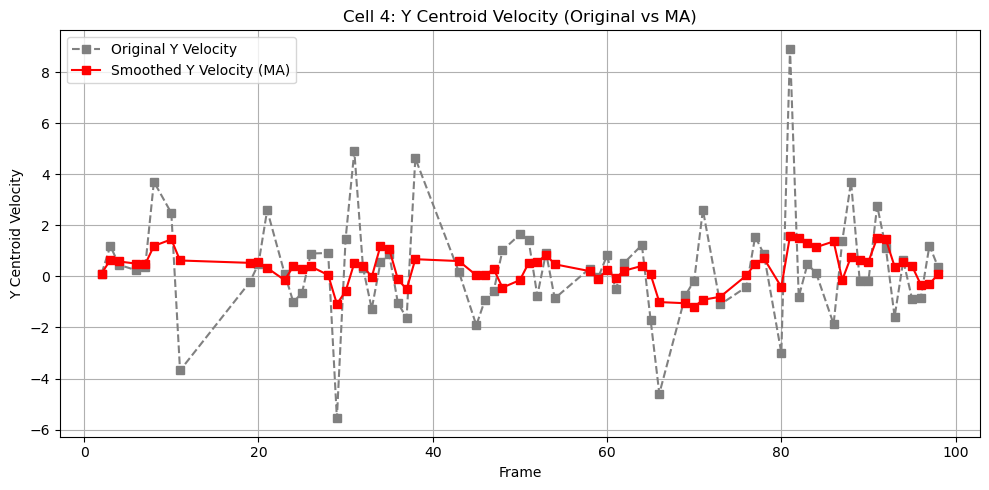

In [3]:
def plot_cell_velocity_comparison(output_directory, cell_id, window_size):
    # File paths
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")

    # Check if files exist
    if not os.path.exists(ma_csv_path) or not os.path.exists(original_csv_path):
        print(f"Error: Required CSV files not found in {output_directory}")
        return

    # Load data
    df_ma = pd.read_csv(ma_csv_path)
    df_orig = pd.read_csv(original_csv_path)

    # Filter by Cell ID
    cell_ma = df_ma[df_ma["Cell Number"] == cell_id]
    cell_orig = df_orig[df_orig["Cell Number"] == cell_id]

    if cell_ma.empty or cell_orig.empty:
        print(f"No data found for Cell ID: {cell_id}")
        return

    # Sort frames just in case
    cell_ma = cell_ma.sort_values(by="Frame")
    cell_orig = cell_orig.sort_values(by="Frame")

    # Plot X Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["X_Centroid_Velocity"], marker='o', linestyle='--', color='gray', label='Original X Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["X_Centroid_Velocity_MA"], marker='o', linestyle='-', color='blue', label='Smoothed X Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("X Centroid Velocity")
    plt.title(f"Cell {cell_id}: X Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Line_Plot_Frame VS X_Centroid_Velocity_MA{window_size}_{cell_id}.png"))
    plt.show()

    # Plot Y Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["Y_Centroid_Velocity"], marker='s', linestyle='--', color='gray', label='Original Y Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["Y_Centroid_Velocity_MA"], marker='s', linestyle='-', color='red', label='Smoothed Y Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("Y Centroid Velocity")
    plt.title(f"Cell {cell_id}: Y Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Line_Plot_Frame VS Y_Centroid_Velocity_MA{window_size}_{cell_id}.png"))
    plt.show()


# Example Usage
# plot_cell_velocity("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/", cell_id=2, window_size=5)
plot_cell_velocity_comparison("/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/",4,5)


# PCA Analysis of the Moving Average(MA) of all the shape measurements ofthe cells including Centroid Velocity ( colored by X_Centroid_Velocity_MA and Y_Centroid_Velocity_MA)

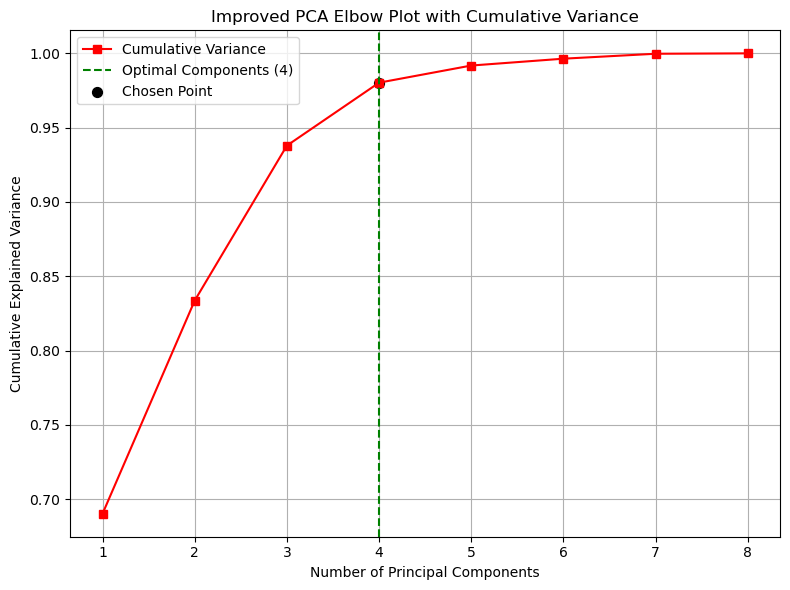

Optimal number of PCA components selected: 4


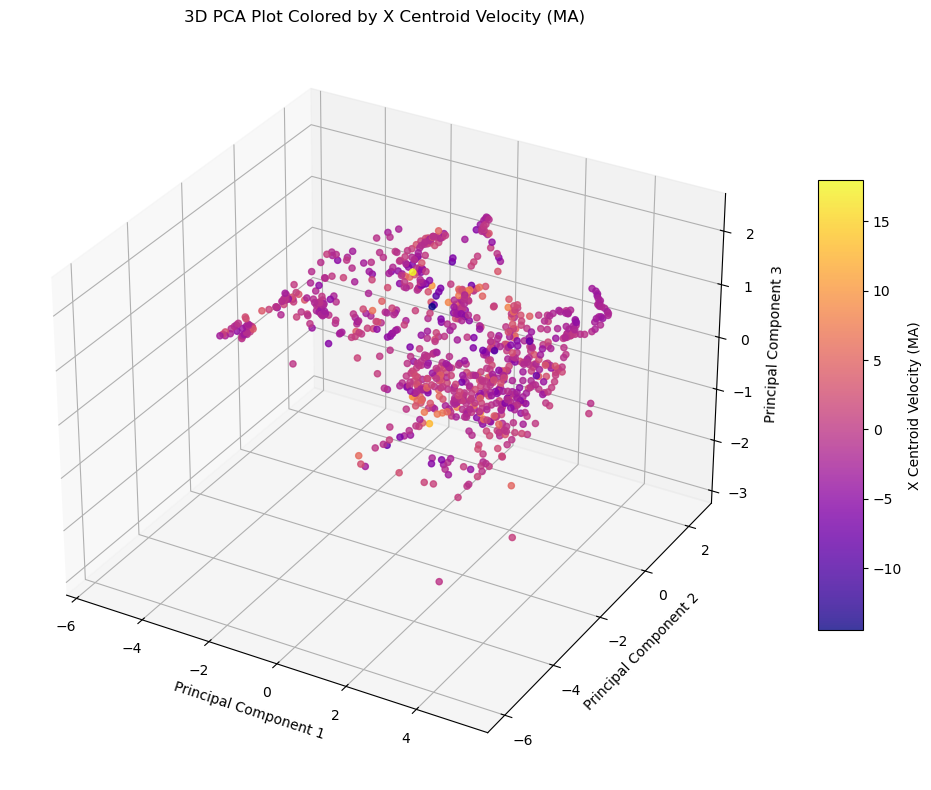

In [ ]:

def apply_pca(csv_path, output_directory, window_size):
    """Load CSV, apply PCA with the optimal number of components, generate improved elbow plot, and create 3D PCA plots."""

    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]

    mini_df = df[selected_columns].copy()

    # Standardize features (excluding Cell Number and velocities)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]))

    # PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Determine the optimal number of components
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Plot Elbow Graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=50, label="Chosen Point")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Improved PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_Elbow_Plot_{window_size}.png"))
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    pca_result = pca.fit_transform(X_scaled)

    # Convert to DataFrame
    pca_columns = [f"PCA{i+1}" for i in range(optimal_components)]
    pca_df = pd.DataFrame(pca_result, columns=pca_columns)
    pca_df["Cell Number"] = mini_df["Cell Number"]
    # pca_df["Convexity_MA"] = mini_df["Convexity_MA"]
    pca_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]

    # 3D PCA Scatter Plot Colored by X Centroid Velocity
    # fig = plt.figure(figsize=(12, 8))
    # ax = fig.add_subplot(111, projection='3d')
    # sc = ax.scatter(pca_df["PCA1"], pca_df["PCA2"], pca_df["PCA3"], c=pca_df["Convexity_MA"], cmap='viridis', alpha=0.8)
    # ax.set_title("3D PCA Plot Colored by Convexity (MA)")
    # ax.set_xlabel("Principal Component 1")
    # ax.set_ylabel("Principal Component 2")
    # ax.set_zlabel("Principal Component 3")
    # cbar = plt.colorbar(sc, ax=ax, shrink=0.6, aspect=10)
    # cbar.set_label("Convexity (MA)")
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_Plot_Convexity_MA_{window_size}.png"))
    # plt.show()


    # 3D PCA Scatter Plot Colored by Y Centroid Velocity
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc_y = ax.scatter(pca_df["PCA1"], pca_df["PCA2"], pca_df["PCA3"], c=pca_df["X_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8)
    ax.set_title("3D PCA Plot Colored by X Centroid Velocity (MA)")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    cbar_y = plt.colorbar(sc_y, ax=ax, shrink=0.6, aspect=10)
    cbar_y.set_label("X Centroid Velocity (MA)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"PCA_Plot_X_Centroid_Velocity_MA_{window_size}.png"))
    plt.show()


# Example usage
# "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"
window_size=5
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
apply_pca(csv_path, output_directory,window_size)


# t-SNE Analysis of the Moving Average(MA) of all the shape measurements ofthe cells including Centroid Velocity ( colored by X_Centroid_Velocity_MA and Y_Centroid_Velocity_MA)

Optimal PCA components to retain 95% variance: 4
PCA Variance Explained with 4 components: 0.9803


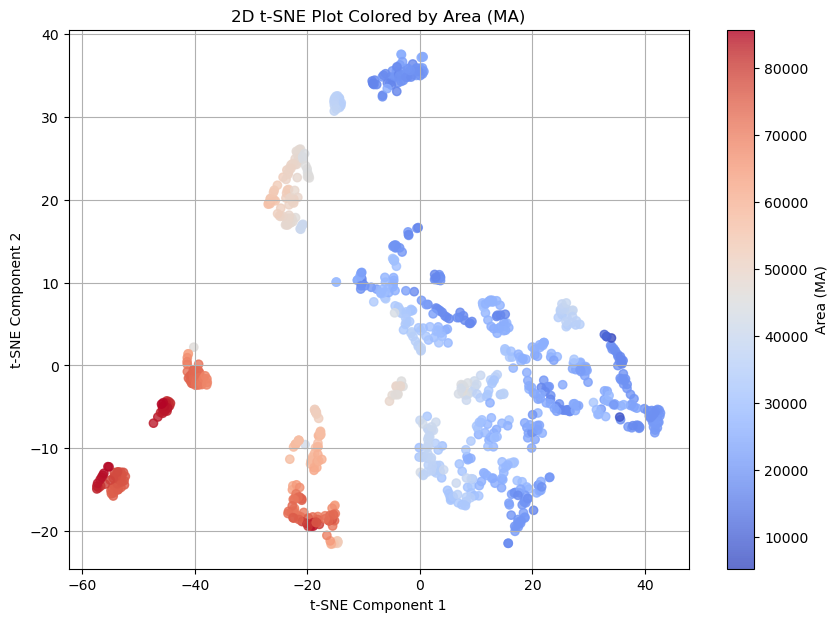

In [16]:

def apply_tsne(csv_path, output_directory,window_size ,variance_threshold=0.95, tsne_perplexity=30):
    """Load CSV, apply PCA for variance retention, then use t-SNE for 2D visualization."""
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Select relevant numeric features
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
    # selected_columns = ["Cell Number", "Area_MA", "Perimeter", "Extent", "Solidity", "Compactness",
    #                     "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    mini_df = df[selected_columns].copy()    
    
    # Drop 'Cell Number' for feature scaling
    feature_cols = mini_df.drop(columns=["Cell Number","X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components dynamically
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=44)
    X_tsne = tsne.fit_transform(X_pca)

    # Convert to DataFrame
    tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
    tsne_df["Cell Number"] = mini_df["Cell Number"]
    tsne_df["Area_MA"] = mini_df["Area_MA"]
    # tsne_df["Y_Centroid_Velocity_MA"] = mini_df["Y_Centroid_Velocity_MA"]

    # 2D t-SNE Scatter Plot Colored by X_Centroid_Velocity
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(tsne_df["TSNE1"], tsne_df["TSNE2"], c=tsne_df["Area_MA"], cmap='coolwarm', alpha=0.8)
    plt.colorbar(sc, label="Area (MA)")
    plt.title("2D t-SNE Plot Colored by Area (MA)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)

    # Add cell number annotations
    # for i, txt in enumerate(tsne_df["Cell Number"]):
    #     plt.text(tsne_df["TSNE1"].iloc[i], tsne_df["TSNE2"].iloc[i], str(txt), fontsize=5, color='black')
    plt.savefig(os.path.join(output_directory, f"t-SNE Plot Colored by Area_MA_{window_size}.png"))
    plt.show()

    # # 2D t-SNE Scatter Plot Colored by Y_Centroid_Velocity
    # plt.figure(figsize=(10, 7))
    # sc_y = plt.scatter(tsne_df["TSNE1"], tsne_df["TSNE2"], c=tsne_df["Y_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8)
    # plt.colorbar(sc_y, label="Y Centroid Velocity (MA)")
    # plt.title("2D t-SNE Plot Colored by Y Centroid Velocity(MA)")
    # plt.xlabel("t-SNE Component 1")
    # plt.ylabel("t-SNE Component 2")
    # plt.grid(True)

    # # Add cell number annotations
    # # for i, txt in enumerate(tsne_df["Cell Number"]):
    # #     plt.text(tsne_df["TSNE1"].iloc[i], tsne_df["TSNE2"].iloc[i], str(txt), fontsize=5, color='black')
    # plt.savefig(os.path.join(output_directory, f"t-SNE Plot Colored by Y-Centroid_Velocity_MA_{window_size}.png"))
    # plt.show()

    return tsne_df



# # Run the analysis
# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
# output_directory = "/home/MinaHossain/EmbedTrack/Shape-Moving_Average/"
# csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# # Apply PCA first, then t-SNE
# # apply_pca(csv_file)
# tsne_results = apply_tsne(csv_file)

# # "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"
window_size=5
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
tsne_results=apply_tsne(csv_path, output_directory,window_size)




# Display the first few rows
# print(tsne_results.head(10))





# PHATE Analysis of the Moving Average(MA) of all the shape measurements ofthe cells including Centroid Velocity ( colored by X_Centroid_Velocity_MA and Y_Centroid_Velocity_MA)

Optimal PCA components to retain 95% variance: 4
PCA Variance Explained with 4 components: 0.9803
Calculating PHATE...
  Running PHATE on 910 observations and 4 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating optimal t...


    Automatically selected t = 15
  Calculated optimal t in 0.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.38 seconds.
Calculated PHATE in 0.58 seconds.


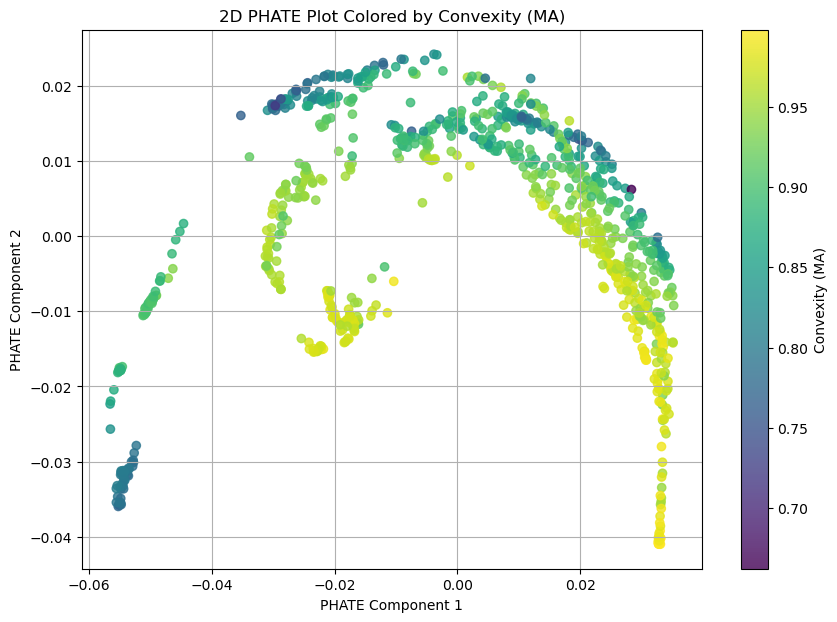

     PHATE1    PHATE2  Cell Number  Convexity_MA  Cluster
0  0.035135 -0.014206            2      0.967665        2
1  0.024298 -0.002142            3      0.976929        0
2  0.021868  0.003083            6      0.927020        0
3 -0.003834  0.024174            8      0.826487        3
4  0.033045 -0.039178           11      0.997901        2
5 -0.052344 -0.027849           12      0.792740        4
6  0.035112 -0.014100            2      0.961058        2
7  0.020794  0.006737            3      0.936863        0
8 -0.005176  0.010455            4      0.952567        3
9 -0.016752 -0.011922            5      0.965595        1


In [25]:


def apply_phate(csv_path,output_directory,window_size, variance_threshold=0.95, k_clusters=5):
    """Load CSV, apply PCA for variance retention, use PHATE for 2D visualization, and apply k-means clustering."""
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Select relevant numeric features
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
   
    
    mini_df = df[selected_columns].copy()    
    
    # Drop 'Cell Number' for feature scaling
    feature_cols = mini_df.drop(columns=["Cell Number","X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()
    
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components dynamically
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
    X_phate = phate_operator.fit_transform(X_pca)

    # Convert to DataFrame
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    phate_df["Convexity_MA"] = mini_df["Convexity_MA"]
    # phate_df["Y_Centroid_Velocity_MA"] = mini_df["Y_Centroid_Velocity_MA"]

    # Apply k-means clustering on PHATE embedding
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_phate)
    phate_df["Cluster"] = clusters

    # 2D PHATE Scatter Plot Colored by Clusters
    # plt.figure(figsize=(7, 5))
    # scprep.plot.scatter2d(
    #     X_phate, c=clusters, cmap=sns.husl_palette(k_clusters), s=10,
    #     figsize=(7,5), ticks=None, label_prefix='PHATE',
    #     legend_anchor=(1,1), fontsize=12, title=f'PHATE Clusters (k={k_clusters})'
    # )
    # plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
    # plt.show()

    # 2D PHATE Scatter Plot Colored by X_Centroid_Velocity #cmap='coolwarm'
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Convexity_MA"], cmap='viridis', alpha=0.8)
    plt.colorbar(sc, label="Convexity (MA)")
    plt.title("2D PHATE Plot Colored by Convexity (MA)")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory,f"PHATE Plot Colored by Convexity_MA_{window_size}.png"))
    plt.show()

    # # 2D PHATE Scatter Plot Colored by Y_Centroid_Velocity
    # plt.figure(figsize=(10, 7))
    # sc_y = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Y_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8)
    # plt.colorbar(sc_y, label="Y Centroid Velocity(MA)")
    # plt.title("2D PHATE Plot Colored by Y Centroid Velocity(MA)")
    # plt.xlabel("PHATE Component 1")
    # plt.ylabel("PHATE Component 2")
    # plt.grid(True)
    # plt.savefig(os.path.join(output_directory, f"PHATE Plot Colored by Y-Centroid_Velocity_{window_size}.png"))
    # plt.show()

    return phate_df




# # "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"
window_size=5
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
# output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
phate_results = apply_phate(csv_path, output_directory,window_size)

# Display the first few rows
print(phate_results.head(10))


# Regression Analysis

In [32]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""

    start_time = time.time()

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    previous_centroids = {}
    previous_frames = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]
                    y_dist = centroid[1] - prev_centroid[1]
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x
                y_centroid_distance = centroid[1] - prev_y
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent", "Circularity", "Convexity", "Elongation", "Compactness", 
                                            "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])

    # df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]
    df = df.sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)


    # Keep only Cell Numbers that appear at least 30 times
    frame_num=30
    cell_counts = df["Cell Number"].value_counts()
    valid_cells = cell_counts[cell_counts >= 30].index
    df = df[df["Cell Number"].isin(valid_cells)]


    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(output_directory, exist_ok=True)
    window_size = 5

    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}-{frame_num}.csv")
    df.to_csv(original_csv_path, index=False)

    moving_average_variables = df.columns.difference(["Cell Number", "Frame"])
    ma_df = df[["Cell Number", "Frame"]].copy()

    for var in moving_average_variables:
        ma_df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")
    ma_df.to_csv(ma_csv_path, index=False)

    # Merge original and moving average DataFrames
    merged_df = pd.merge(df, ma_df.drop(columns=["Cell Number", "Frame"]), left_index=True, right_index=True)
    merged_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Merged_{window_size}-{frame_num}.csv")
    merged_df.to_csv(merged_csv_path, index=False)

    print(f"\n✅ Original CSV saved at: {original_csv_path}")
    print(f"✅ Moving Average CSV saved at: {ma_csv_path}")
    print(f"✅ Merged CSV saved at: {merged_csv_path}")

    return df



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))

Found 100 mask files.

✅ Original CSV saved at: /home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_Original_5-30.csv
✅ Moving Average CSV saved at: /home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_MA_5-30.csv
✅ Merged CSV saved at: /home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_Merged_5-30.csv
    Cell Number  Frame     Area    Perimeter  Solidity    Extent  Circularity  \
2             2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
3             2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
4             2      3  18146.0   750.818326  0.806023  0.605432     0.404502   
5             2      4  20733.0   885.144228  0.790009  0.620823     0.332540   
6             2      5  17514.0   668.776695  0.863950  0.647995     0.492077   
7             2      6  19168.0   725.303607  0.834770  0.614359     0.457875   
8             2      7  19780.0   758.859956  0.806228  0.601801     0.431631 


🔍 Data Preview:
   Cell Number  Frame   Area_MA  Centroid_X_MA  Centroid_Y_MA  Circularity_MA  \
0            2      1  20663.00    1309.792746      97.487345        0.538978   
1            2      2  20288.00    1309.440408      96.647287        0.528503   
2            2      3  19574.00    1309.586950      97.500213        0.487169   
3            2      4  19863.75    1309.042292      98.778884        0.448512   
4            2      5  19393.80    1308.491324      98.217798        0.457225   

   Compactness_MA  Convexity_MA  Elongation_MA  Extent_MA  Perimeter_MA  \
0        0.614792      0.967665       0.554315   0.620678    694.090404   
1        0.609738      0.961058       0.561202   0.631765    694.554870   
2        0.605805      0.928476       0.561765   0.622988    713.309355   
3        0.610504      0.890205       0.547940   0.622446    756.268073   
4        0.607764      0.900788       0.560817   0.627556    738.769798   

   Solidity_MA  X_Centroid_Distance_MA  X_Cen

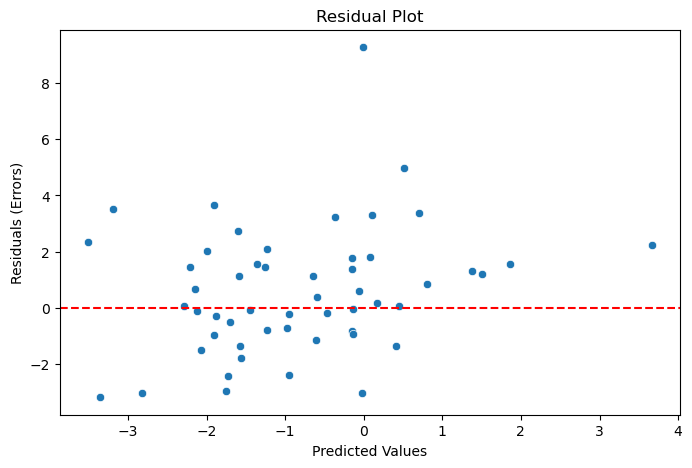

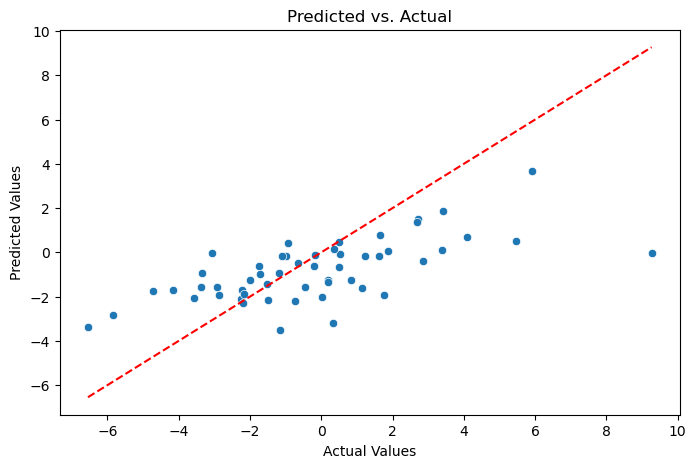


📊 Model Performance:
Mean Squared Error (MSE): 5.3534
R-squared: 0.3632

🌟 Feature Importances (Random Forest):
Area_MA: 0.1390
Perimeter_MA: 0.0724
Extent_MA: 0.2224
Solidity_MA: 0.1183
Compactness_MA: 0.0929
Elongation_MA: 0.1068
Circularity_MA: 0.0652
Convexity_MA: 0.1830


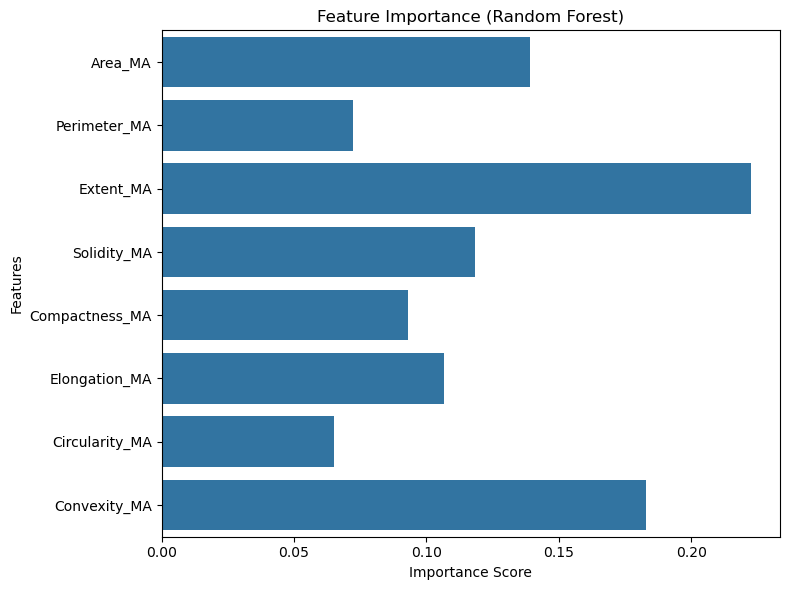

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def run_regression_analysis(csv_path, method="ridge", alpha=1.0, n_estimators=100):
    """
    Performs regression analysis on X_Centroid_Velocity with Ridge, Lasso, or Random Forest regression.
    Runs on all data (ignores cell_id).
    """
    df = pd.read_csv(csv_path)

    print("\n🔍 Data Preview:")
    print(df.head())

    print("\n📊 Dataset Summary:")
    print(df.describe())

    print("\n🔍 Checking for NaN values:")
    print(df.isnull().sum())

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    print("\n📊 Correlation with Target Variable:")
    print(df[features + [target]].corr()[target].sort_values(ascending=False))

    X = df[features]
    y = df[target]

    if df.shape[0] < 10:
        print(f"\n⚠ Dataset is too small for reliable train-test split ({df.shape[0]} rows). Using entire data for training.")
        X_train, X_test, y_train, y_test = X, X, y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        print(f"\n📊 Train-Test Split: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

    if method.lower() == "ridge":
        model = Ridge(alpha=alpha)
        print(f"\n🚀 Applying Ridge Regression with alpha={alpha}")
    elif method.lower() == "lasso":
        model = Lasso(alpha=alpha)
        print(f"\n🚀 Applying Lasso Regression with alpha={alpha}")
    elif method.lower() == "random_forest":
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        print(f"\n🌲 Applying Random Forest Regression with {n_estimators} trees")
    else:
        raise ValueError("Invalid method. Choose 'ridge', 'lasso', or 'random_forest'.")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    y_mean = np.mean(y_train)
    mse_baseline = mean_squared_error(y_test, np.full_like(y_test, y_mean))
    print(f"\n📊 Baseline Model (Predicting Mean): MSE = {mse_baseline:.4f}")

    residuals = y_test - y_pred

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Errors)")
    plt.title("Residual Plot")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual")
    plt.show()

    print("\n📊 Model Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    if method.lower() == "random_forest":
        print("\n🌟 Feature Importances (Random Forest):")
        importances = model.feature_importances_
        for feat, score in zip(features, importances):
            print(f"{feat}: {score:.4f}")

        plt.figure(figsize=(8, 6))
        sns.barplot(x=importances, y=features)
        plt.title("Feature Importance (Random Forest)")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

    return model


window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

reg_results_rf_all = run_regression_analysis(csv_path, method="random_forest", n_estimators=100)



🔍 Data Preview:
   Cell Number  Frame   Area_MA  Centroid_X_MA  Centroid_Y_MA  Circularity_MA  \
0            2      1  20663.00    1309.792746      97.487345        0.538978   
1            2      2  20288.00    1309.440408      96.647287        0.528503   
2            2      3  19574.00    1309.586950      97.500213        0.487169   
3            2      4  19863.75    1309.042292      98.778884        0.448512   
4            2      5  19393.80    1308.491324      98.217798        0.457225   

   Compactness_MA  Convexity_MA  Elongation_MA  Extent_MA  Perimeter_MA  \
0        0.614792      0.967665       0.554315   0.620678    694.090404   
1        0.609738      0.961058       0.561202   0.631765    694.554870   
2        0.605805      0.928476       0.561765   0.622988    713.309355   
3        0.610504      0.890205       0.547940   0.622446    756.268073   
4        0.607764      0.900788       0.560817   0.627556    738.769798   

   Solidity_MA  X_Centroid_Distance_MA  X_Cen

/home/MinaHossain/anaconda3/envs/Shp_chc/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



✅ Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
✅ Best Cross-Validated R²: 0.0663


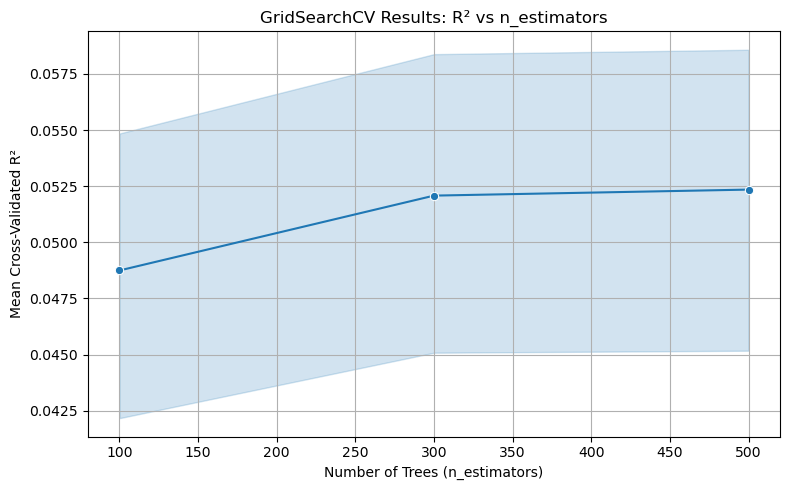

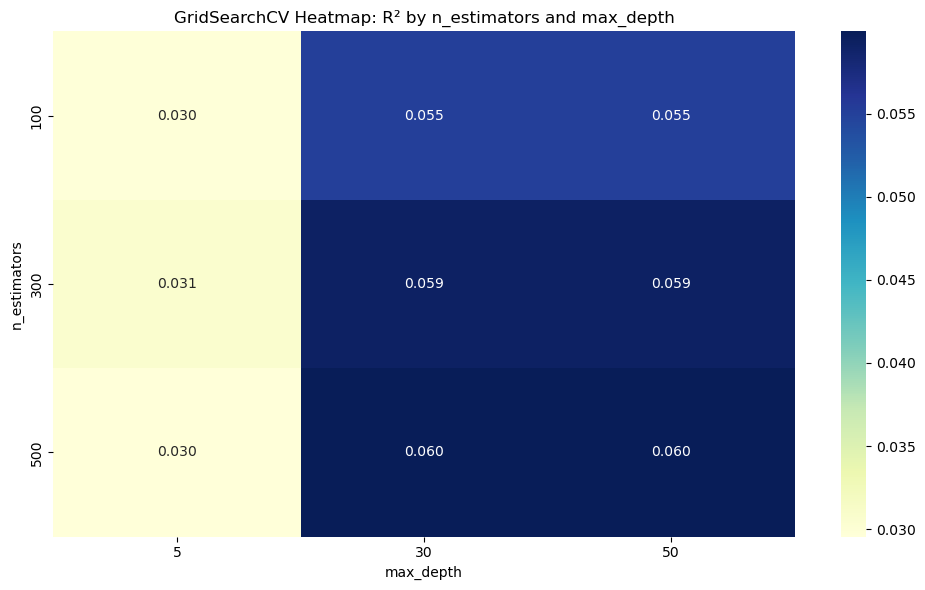


📊 Final Model Performance:
Mean Squared Error (MSE): 1.7868
R-squared: 0.4067


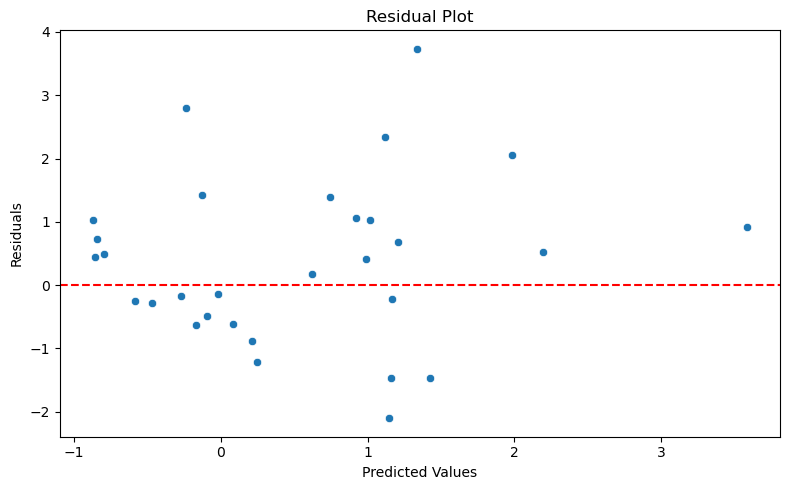

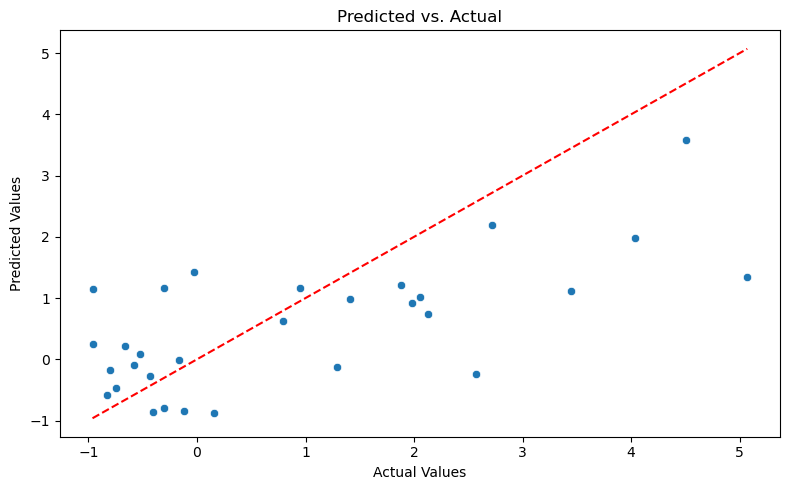

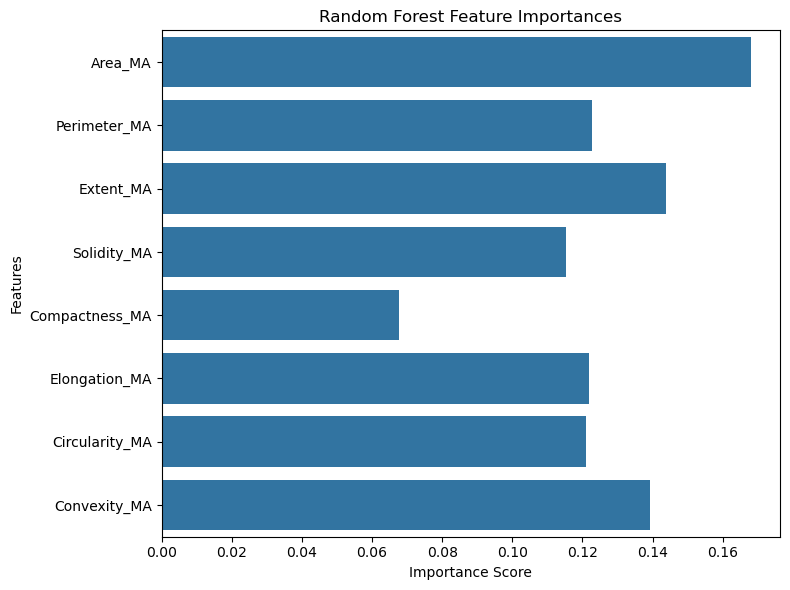

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def run_enhanced_rf_regression(csv_path):
    """
    Enhanced Regression Pipeline using Random Forest + GridSearchCV with standardization, target transformation,
    and bulletproof NaN handling.
    """
    df = pd.read_csv(csv_path)

    print("\n🔍 Data Preview:")
    print(df.head())

    print("\n📊 Dataset Summary:")
    print(df.describe())

    print("\n🔍 Checking for NaN values:")
    print(df.isnull().sum())

    features = [
        "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
        "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    # === Check column existence ===
    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in the CSV: {missing_cols}")

    # === Drop NaNs only for selected features and target ===
    df = df.dropna(subset=features + [target]).copy()

    print("\n📊 Correlation with Target Variable:")
    print(df[features + [target]].corr()[target].sort_values(ascending=False))

    # === Standardize Features ===
    scaler = StandardScaler()
    X = df[features]
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    # === Target Transformation ===
    y = df[target]
    y = np.log1p(y)  # log1p transformation

    # Final check for any remaining NaNs
    if np.any(np.isnan(y)):
        print("⚠ Still NaNs in y after transformation. Dropping those rows now...")
        non_nan_idx = ~np.isnan(y)
        X_scaled = X_scaled[non_nan_idx]
        y = y[non_nan_idx]

    # === Train-Test Split ===
    if len(y) < 10:
        print("\n⚠ Too few samples for reliable train/test split. Using entire dataset.")
        X_train, X_test, y_train, y_test = X_scaled, X_scaled, y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
        print(f"\n📊 Train-Test Split: X_train: {X_train.shape}, X_test: {X_test.shape}")

    # Final sanity check
    print(f"\n✅ NaNs in y_train: {np.isnan(y_train).sum()}, y_test: {np.isnan(y_test).sum()}")

    # === Random Forest with GridSearchCV ===
    rf_model = RandomForestRegressor(random_state=42)

    param_grid = {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 5, 30, 50],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 2]
    }

    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               scoring='r2', cv=10, n_jobs=-1, verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("\n✅ Best Hyperparameters:")
    print(grid_search.best_params_)
    print(f"✅ Best Cross-Validated R²: {grid_search.best_score_:.4f}")

    # === GridSearch Results Plot ===
    cv_results = pd.DataFrame(grid_search.cv_results_)

    # Lineplot: R² vs n_estimators
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=cv_results, x="param_n_estimators", y="mean_test_score", marker="o")
    plt.title("GridSearchCV Results: R² vs n_estimators")
    plt.xlabel("Number of Trees (n_estimators)")
    plt.ylabel("Mean Cross-Validated R²")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Heatmap: R² for n_estimators vs max_depth
    pivot = cv_results.pivot_table(index="param_n_estimators", columns="param_max_depth", values="mean_test_score")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("GridSearchCV Heatmap: R² by n_estimators and max_depth")
    plt.xlabel("max_depth")
    plt.ylabel("n_estimators")
    plt.tight_layout()
    plt.show()

    # === Predict and Evaluate ===
    y_pred_trans = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_trans)  # Reverse log1p
    y_test_orig = np.expm1(y_test)

    mse = mean_squared_error(y_test_orig, y_pred)
    r2 = r2_score(y_test_orig, y_pred)

    print("\n📊 Final Model Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # === Residuals Plot ===
    residuals = y_test_orig - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.tight_layout()
    plt.show()

    # === Predicted vs Actual Plot ===
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test_orig, y=y_pred)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual")
    plt.tight_layout()
    plt.show()

    # === Feature Importance Plot ===
    importances = best_model.feature_importances_
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances, y=features)
    plt.title("Random Forest Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    return best_model




window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

reg_model = run_enhanced_rf_regression(csv_path)




🔍 Running PyTorch FNN Regression for Cell ID: 4
Epoch 1/200 - Loss: 12.7492
Epoch 10/200 - Loss: 11.0876
Epoch 20/200 - Loss: 8.6839
Epoch 30/200 - Loss: 6.7627
Epoch 40/200 - Loss: 6.0273
Epoch 50/200 - Loss: 5.2582
Epoch 60/200 - Loss: 4.7321
Epoch 70/200 - Loss: 4.2898
Epoch 80/200 - Loss: 3.9447
Epoch 90/200 - Loss: 3.5790
Epoch 100/200 - Loss: 3.4333
Epoch 110/200 - Loss: 3.2306
Epoch 120/200 - Loss: 2.9915
Epoch 130/200 - Loss: 2.8282
Epoch 140/200 - Loss: 2.6640
Epoch 150/200 - Loss: 2.5870
Epoch 160/200 - Loss: 2.2971
Epoch 170/200 - Loss: 2.1504
Epoch 180/200 - Loss: 2.0137
Epoch 190/200 - Loss: 1.9378
Epoch 200/200 - Loss: 1.8636

📊 PyTorch FNN Performance:
Mean Squared Error (MSE): 1.4966
R-squared: 0.7465


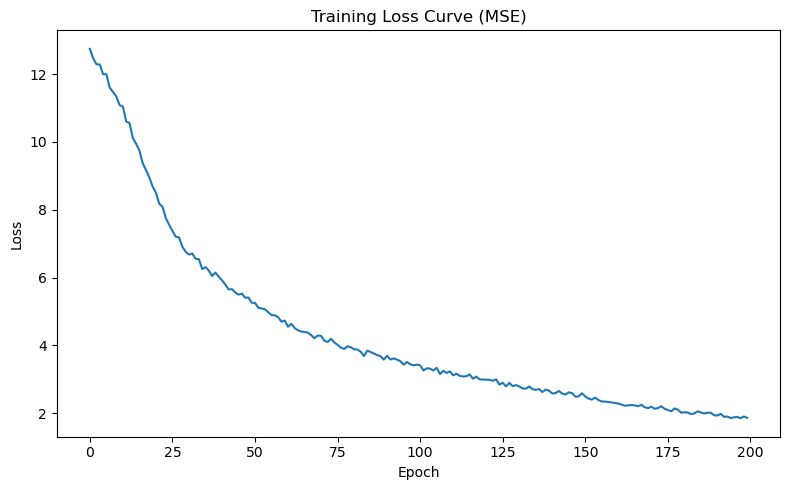

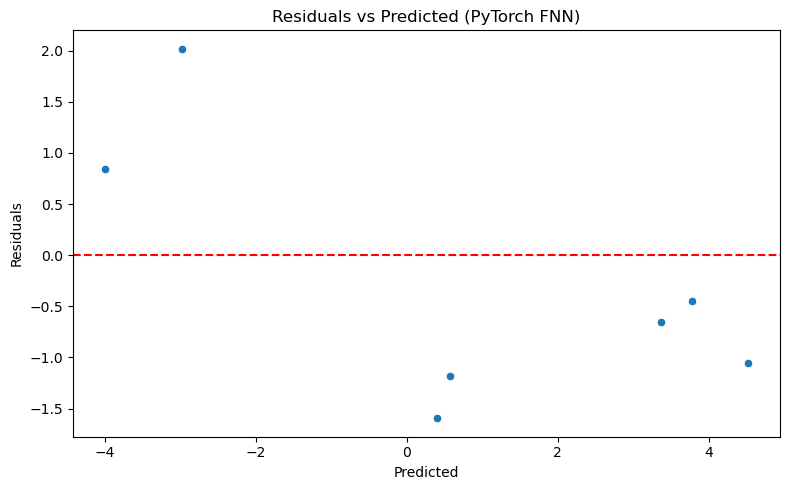

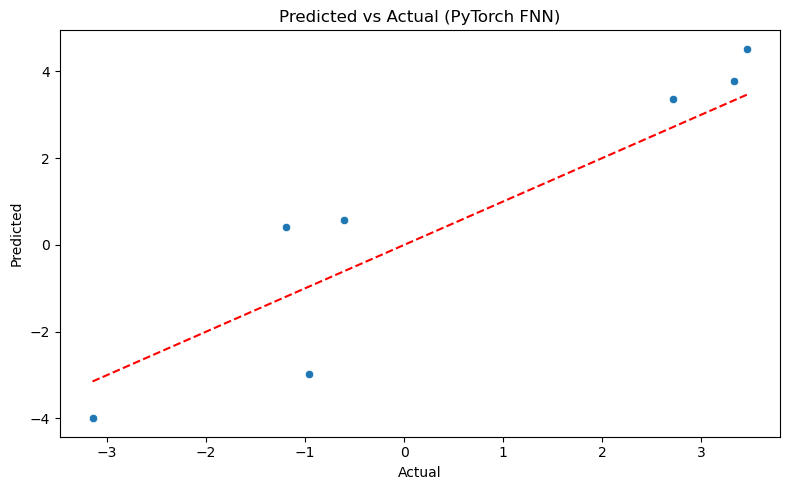

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_fnn_pytorch(csv_path, cell_id=None, epochs=100, batch_size=16, lr=0.001, hidden_sizes=(64, 32)):
    df = pd.read_csv(csv_path)

    if cell_id is not None:
        df = df[df["Cell Number"] == cell_id]
        print(f"\n🔍 Running PyTorch FNN Regression for Cell ID: {cell_id}")
        if df.shape[0] < 10:
            print(f"⚠ Not enough data points for Cell ID {cell_id} ({df.shape[0]} rows). Skipping regression.")
            return None

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    X = df[features].values.astype(np.float32)
    y = df[target].values.astype(np.float32).reshape(-1, 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if len(df) < 10:
        print("⚠ Small dataset, using entire data for training and testing.")
        X_train = X_test = X
        y_train = y_test = y
    else:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define FNN model
    class FNN(nn.Module):
        def __init__(self, input_size, hidden_sizes):
            super(FNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_sizes[0])
            self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
            self.out = nn.Linear(hidden_sizes[1], 1)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            return self.out(x)

    model = FNN(input_size=X_train.shape[1], hidden_sizes=hidden_sizes)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test.flatten()

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 PyTorch FNN Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Plot loss curve
    plt.figure(figsize=(8,5))
    plt.plot(train_losses)
    plt.title("Training Loss Curve (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

    # Residual plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted (PyTorch FNN)")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual (PyTorch FNN)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    return model


window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")

fnn_model_torch = run_fnn_pytorch(csv_path, cell_id=4, epochs=200, batch_size=16)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from itertools import product
from fnn_pytorch_gridsearch import run_fnn_pytorch, grid_search_fnn


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001, hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8), apply_log_transform=True):
    """
    Feedforward Neural Network Regression on full dataset using PyTorch.
    Includes feature scaling, target transformation, and advanced performance plots.
    """
    df = pd.read_csv(csv_path)

    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")
    
    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    class FNN(nn.Module):
        def __init__(self, input_size, hidden_sizes):
            super(FNN, self).__init__()
            layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], 1))
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test.flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 PyTorch FNN Performance (All Cells):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # ---- Plots ----

    # 1. Training Loss Curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Residuals vs Predicted
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # 3. Predicted vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    # 4. Residual Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # 5. Cumulative Distribution of Absolute Errors
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6. Q-Q Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    # 7. Absolute Error vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()

    return model



# window_size = 5
# output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    """
    Manual Grid Search over FNN hyperparameters using run_fnn_pytorch().
    Tracks MSE, R², and saves best model configuration and results table.
    """
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    # Generate all hyperparameter combinations
    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")
        
        model_name = f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"

        model, mse, r2 = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False  # Save only best model later
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 4)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": model_name
            }
            best_model = model
            if save_best_model:
                torch.save(model.state_dict(), model_name)
                print(f"💾 New best model saved as: {model_name}")

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, results_df




# reg_model = run_enhanced_rf_regression(csv_path)
# run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001, hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8), apply_log_transform=True):
param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

best_model, best_config, results_df = fnn_module.grid_search_fnn(
    csv_path="your_path.csv",
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)



fnn_model_all_cells = run_fnn_pytorch(
    csv_path,
    epochs=500,
    batch_size=8,
    lr=0.001,
    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8)  # 8 hidden layers
)



window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

KeyboardInterrupt: 

### FFD Network to Predict X_Centroid_Velocity

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test.flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 PyTorch FNN Performance (All Cells):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Save model if required
    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    # Visualization (same as before - omitted here for brevity)
    # You can copy/paste from your original script if needed.

    return model, mse, r2


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model_name = f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"

        model, mse, r2 = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False  # Save only best model later
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 4)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": model_name
            }
            best_model = model
            if save_best_model:
                torch.save(model.state_dict(), model_name)
                print(f"💾 New best model saved as: {model_name}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, results_df




window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

: 


🔍 Running PyTorch FNN Regression for Cell ID: 4
Epoch 1/150 - Loss: 12.7087
Epoch 10/150 - Loss: 11.2253
Epoch 20/150 - Loss: 6.9772
Epoch 30/150 - Loss: 4.6463
Epoch 40/150 - Loss: 4.6335
Epoch 50/150 - Loss: 3.0479
Epoch 60/150 - Loss: 1.5859
Epoch 70/150 - Loss: 1.1550
Epoch 80/150 - Loss: 0.9414
Epoch 90/150 - Loss: 0.7415
Epoch 100/150 - Loss: 0.5406
Epoch 110/150 - Loss: 0.4057
Epoch 120/150 - Loss: 0.3750
Epoch 130/150 - Loss: 0.2876
Epoch 140/150 - Loss: 0.2799
Epoch 150/150 - Loss: 0.2116

📊 PyTorch Deep FNN Performance:
Mean Squared Error (MSE): 2.7129
R-squared: 0.5404


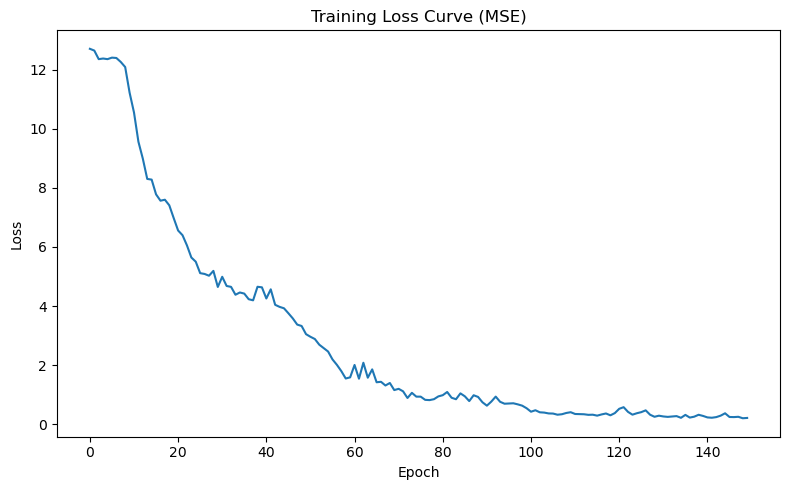

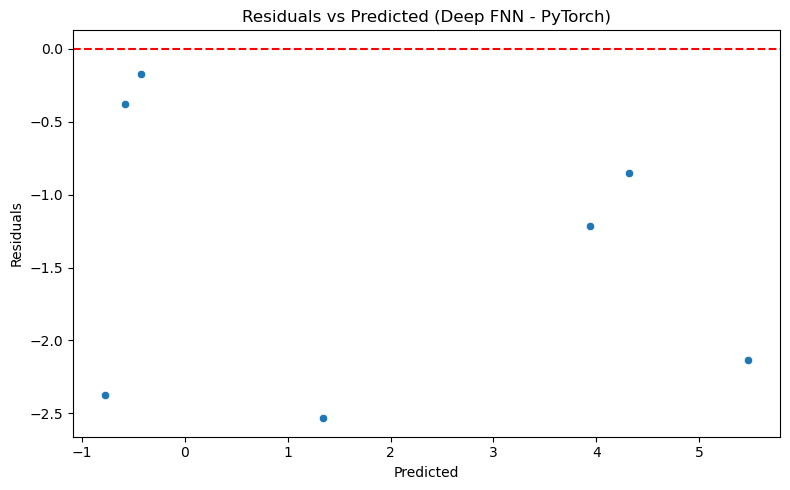

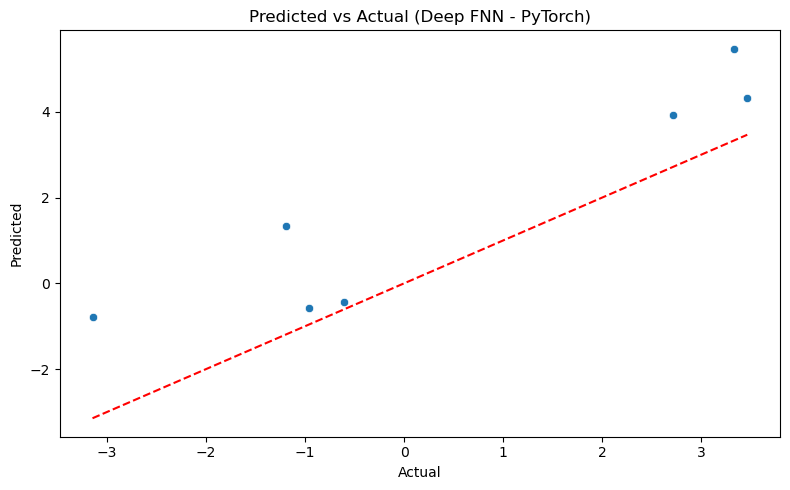

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_fnn_pytorch(csv_path, cell_id=None, epochs=100, batch_size=16, lr=0.001, hidden_size=64, num_hidden_layers=10):
    df = pd.read_csv(csv_path)

    if cell_id is not None:
        df = df[df["Cell Number"] == cell_id]
        print(f"\n🔍 Running PyTorch FNN Regression for Cell ID: {cell_id}")
        if df.shape[0] < 10:
            print(f"⚠ Not enough data points for Cell ID {cell_id} ({df.shape[0]} rows). Skipping regression.")
            return None

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    X = df[features].values.astype(np.float32)
    y = df[target].values.astype(np.float32).reshape(-1, 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if len(df) < 10:
        print("⚠ Small dataset, using entire data for training and testing.")
        X_train = X_test = X
        y_train = y_test = y
    else:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define FNN model with 10 hidden layers
    class DeepFNN(nn.Module):
        def __init__(self, input_size, hidden_size, num_hidden_layers):
            super(DeepFNN, self).__init__()
            layers = []
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            for _ in range(num_hidden_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_size, 1))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    model = DeepFNN(input_size=X_train.shape[1], hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test.flatten()

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 PyTorch Deep FNN Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Plot loss curve
    plt.figure(figsize=(8,5))
    plt.plot(train_losses)
    plt.title("Training Loss Curve (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

    # Residual plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted (Deep FNN - PyTorch)")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual (Deep FNN - PyTorch)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    return model


window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")

fnn_model_torch = run_fnn_pytorch(csv_path, cell_id=4, epochs=150, batch_size=16, hidden_size=64, num_hidden_layers=10)
